# Applied Machine Learning: Assignment \#6

### Sheetal Parikh
EN.605.631.81<br>
March 8, 2021
***
***

*Continuing to the previous machine learning problem, let's get back to the pre-processed dataset Suicide Rates Overview 1985 to 2016 file. We would like to have a machine learning model to predict the suicide rate or even more explanatory target variables, in order to answer questions like what is the probability of a male, of this age, in that country to commit suicide.* 

## Problem 1
*What is the dependent variable you decided? Why?*

After exploring the suicide dataset in Assignment 3, I believe the Suicide Rates/100k population should be the dependent variable. The Suicide Rate/100k is a variable that can be compared between the different countries of various sizes. A similar variable, such as the number of suicides, would not be a good dependent variable because the overall number of suicides may just be higher in a country with a higher population. For example, 100,000 suicides in a heavily populated country means something different to 100,000 suicides in a country with a small population.

### Preprocessing Data Set similar to Module 3 Homework

In [1]:
# imports for notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn import datasets, svm, metrics
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import os 

#checking current directory
#print(os.getcwd() + "\n")

# change the current directory 
# to specified directory 
os.chdir(r"C:\Users\Sheetal\Documents\Sheetal") 

#Read in file
relative_path = 'datasets/master.csv'
df_org = pd.read_csv(relative_path)

# Sanity check
print(f'N rows={len(df_org)}, M columns={len(df_org.columns)}')

#print first few rows to visualize dataset
df_org.head()

N rows=27820, M columns=12


,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [2]:
#renaming suicides/100k pop column
df_org.rename(columns = {'suicides/100k pop':'suicides_per_100k'}, inplace = True) 

df_org.isnull().sum()

country                   0
year                      0
sex                       0
age                       0
suicides_no               0
population                0
suicides_per_100k         0
country-year              0
HDI for year          19456
 gdp_for_year ($)         0
gdp_per_capita ($)        0
generation                0
dtype: int64

In [3]:
print(f'Column Names:')

#printing column names
print(df_org.columns)

Column Names:
Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides_per_100k', 'country-year', 'HDI for year',
       ' gdp_for_year ($) ', 'gdp_per_capita ($)', 'generation'],
      dtype='object')


In [4]:
#dropping 2016 data because very few data points - data possibly incomplete for 2016
df = df_org[df_org.year != 2016]
print(df.shape)

(27660, 12)


We started out with 27,820 data points and were able to elminate 160 data points due to incomplete data. We can now use the pearson method in pandas to calculate the correlation between variables as well as visualize correlation plots.

In [5]:
df.corr(method = 'pearson')

,year,suicides_no,population,suicides_per_100k,HDI for year,gdp_per_capita ($)
year,1.000000,-0.002953,0.011583,-0.039800,0.366786,0.338854
suicides_no,-0.002953,1.000000,0.616105,0.307103,0.151399,0.062168
population,0.011583,0.616105,1.000000,0.008461,0.102943,0.083006
suicides_per_100k,-0.039800,0.307103,0.008461,1.000000,0.074279,0.002015
HDI for year,0.366786,0.151399,0.102943,0.074279,1.000000,0.771228
gdp_per_capita ($),0.338854,0.062168,0.083006,0.002015,0.771228,1.000000


No variable has a very strong correlation with suicides/100k pop, however, HDI for year appears to have the strongest of the other variables. Also, the number of suicides has a strong correlation with the population. Also, GDP per capita has a strong correlation with HDI.

In [6]:
# converting sex, age, and generation to numerical data - using method similar from Module 3 assignment solution

df2 = df.copy()

df2.generation.replace(['G.I. Generation','Silent','Boomers','Generation X','Millenials','Generation Z'], 
                        [1,2,3,4,5,6], inplace=True)

df2.sex.replace(['female', 'male'], [0, 1], inplace=True)

df2.age.replace(['5-14 years','15-24 years','25-34 years','35-54 years','55-74 years','75+ years'], 
                 [10,20,30,45,65,80], inplace=True)

df2.head(10)

,country,year,sex,age,suicides_no,population,suicides_per_100k,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,1,20,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,4
1,Albania,1987,1,45,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,2
2,Albania,1987,0,20,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,4
3,Albania,1987,1,80,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,1
4,Albania,1987,1,30,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,3
5,Albania,1987,0,80,1,35600,2.81,Albania1987,NaN,"2,156,624,900",796,1
6,Albania,1987,0,45,6,278800,2.15,Albania1987,NaN,"2,156,624,900",796,2
7,Albania,1987,0,30,4,257200,1.56,Albania1987,NaN,"2,156,624,900",796,3
8,Albania,1987,1,65,1,137500,0.73,Albania1987,NaN,"2,156,624,900",796,1
9,Albania,1987,0,10,0,311000,0.00,Albania1987,NaN,"2,156,624,900",796,4


<function matplotlib.pyplot.show(*args, **kw)>

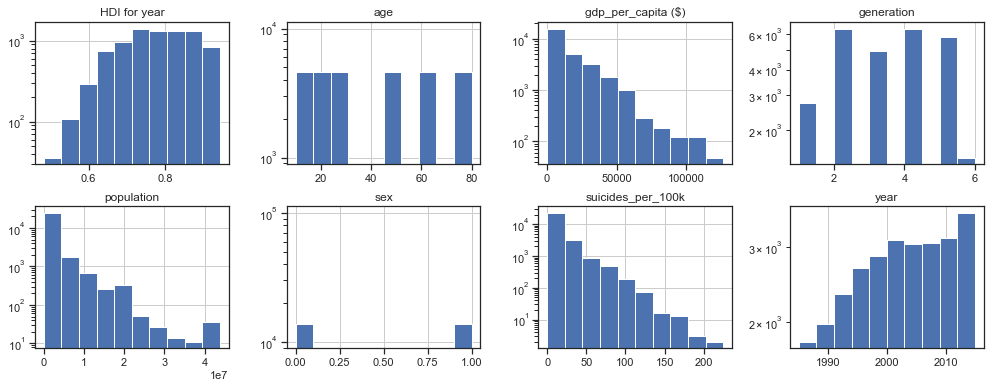

In [7]:
#plotting variables using method from Module 3 assignment solution

df2.hist(column = ['year', 'sex', 'age', 'population', 
                   'suicides_per_100k', 'HDI for year', 'gdp_per_capita ($)', 'generation'],
        log=True,
        figsize=(17, 6), layout=(2,4))

plt.show

In [8]:
#dropping features
df3 = df2.copy()
df3.drop(columns='suicides_no', inplace=True)
df3.drop(columns='population', inplace=True)
df3.drop(columns='country', inplace=True)
df3.drop(columns=' gdp_for_year ($) ', inplace=True)
df3.drop(columns='country-year', inplace=True)
df3.drop(columns='HDI for year', inplace=True)

#printing updated data set
df3.head()

,year,sex,age,suicides_per_100k,gdp_per_capita ($),generation
0,1987,1,20,6.71,796,4
1,1987,1,45,5.19,796,2
2,1987,0,20,4.83,796,4
3,1987,1,80,4.59,796,1
4,1987,1,30,3.28,796,3


For the Module 3 homework, I had choses to keep the following dependent variables: Year, Country, Sex, Age, Generation, and HDI for year.  However, the SVM model I used had a low recall.  I believe recall is important for predicting between a high or low suicide rate.  Having low recall would mean that the model misses out on identifying people who are potentially at a high risk of suicide.  The HDI for year variable has too many null values so I believe using the mean per country may not be sufficient and should just be removed. Also, I decided to remove the country variable because I wanted to limit the number of columns that would be added to the dataset.  I do believe variables such as HDI or GDP per capita would have some impact on suicide rates so since I removed HDI, I decided to keep GDP per capita in it's place.

In [9]:
#checking if we eliminated the NaNs
df3.isnull().sum()

year                  0
sex                   0
age                   0
suicides_per_100k     0
gdp_per_capita ($)    0
generation            0
dtype: int64

In [10]:
print(df3.dtypes)

year                    int64
sex                     int64
age                     int64
suicides_per_100k     float64
gdp_per_capita ($)      int64
generation              int64
dtype: object


***
## Problem 2
*Set the dependent variable into two categories based on a defensible criteria. (Hint: skirts of the probability density function)*


In [11]:
#suicide stats of target variable

target  = df3['suicides_per_100k'].values

target_mean = np.mean(target)
target_stdev = np.std(target)

print(f'Mean of suicides_per_100k = {target_mean:.4f}')
print(f'Standard Deviation of suicides_per_100k = {target_stdev:.4f}') 


Mean of suicides_per_100k = 12.8126
Standard Deviation of suicides_per_100k = 18.9717


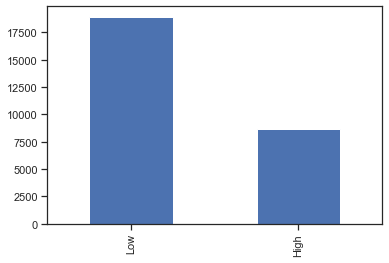

In [12]:
#plotting low and high rate of suicide if using only the mean suicides per 100k as the cuttoff
#from module 3 homeowork solution

suicideRate2 = pd.cut(df3['suicides_per_100k'], bins = [np.NINF, target_mean, np.Infinity], 
                     labels = ["Low", "High"])

suicideRate2.value_counts().plot(kind='bar');

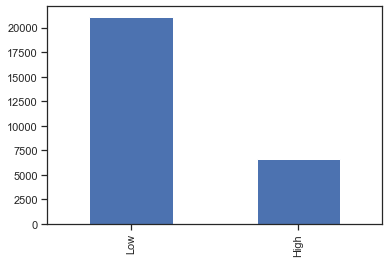

In [13]:
#plotting low and high rate of suicide if using only the mean suicides per 100k + 1/4 the standard deviation 
#of the suicides per 100k as the cuttoff

#from module 3 homeowork solution

suicideRate3 = pd.cut(df3['suicides_per_100k'], bins = [np.NINF, (target_mean + 0.25 * target_stdev), np.Infinity], 
                     labels = ["Low", "High"])

suicideRate3.value_counts().plot(kind='bar');

In [14]:
#listing features

features = list(df3.columns)

features.remove('suicides_per_100k')
print(f'Independent Variables: {features}')

Independent Variables: ['year', 'sex', 'age', 'gdp_per_capita ($)', 'generation']


In [15]:
df4 = df3.copy()
df_mean = df3.copy()

#adding risk column to dataframe
df4['risk'] = df4.suicides_per_100k.copy()
df_mean['risk'] = df_mean.suicides_per_100k.copy()

#if a value in the suicide/100k column is below the mean of the column than it will be considered "low" risk 
#if a value in the suicide/100k column is equal to or above the mean of the column than it will be considered "high" risk
df4['risk'] = np.where(df4.risk < (target_mean + 0.25 * target_stdev), 0, 1)
df_mean['risk'] = np.where(df_mean.risk < df_mean.suicides_per_100k.mean(), 0, 1)

For the module 3 homework, I had used only the mean suicides per 100k as the cutoff between low and high suicides.  I am using that threshold as well as the mean suicides per 100k plus 1/4 the standard deviation of the suicides per 100k to compare whether one threshold works better. A separate column called "risk" is added to show whether the person is being identified as low risk (0) or high risk (1).

In [16]:
print('Threshold for High risk is Mean')
df_mean['risk'].value_counts()

Threshold for High risk is Mean


0    18956
1     8704
Name: risk, dtype: int64

In [17]:
print('Threshold for High risk is Mean + 1/4 the standard deviation')
df4['risk'].value_counts()

Threshold for High risk is Mean + 1/4 the standard deviation


0    21114
1     6546
Name: risk, dtype: int64

As we can see in the graphs and breakdown above, the threshold using only the mean suicide rate has roughly 2000 more people identified as having a high risk of suicide

In [18]:
#removing suicides_per_100k column since it is now redundant with the "risk" column

df4.drop(columns='suicides_per_100k', inplace=True)
df_mean.drop(columns='suicides_per_100k', inplace=True)

In [19]:
df4.head()

,year,sex,age,gdp_per_capita ($),generation,risk
0,1987,1,20,796,4,0
1,1987,1,45,796,2,0
2,1987,0,20,796,4,0
3,1987,1,80,796,1,0
4,1987,1,30,796,3,0


In [20]:
df_mean.head()

,year,sex,age,gdp_per_capita ($),generation,risk
0,1987,1,20,796,4,0
1,1987,1,45,796,2,0
2,1987,0,20,796,4,0
3,1987,1,80,796,1,0
4,1987,1,30,796,3,0


***
## Problems 3 and 4

*Problem 3 - Develop your classification model(s) to solve your defined problem.*

*Problem 4 - Evaluate (and report) the model performance(s) using some of the standard techniques (e.g. 80-20 split, 10-fold cross validation, etc.).*


In [21]:
#splitting dataset - 80% split
#using code from Module 3 notebook

#from sklearn.model_selection import train_test_split

# Preparing the input X matrix and target y vector
X = df4.loc[:, df4.columns != 'risk'].values
y = df4.loc[:, df4.columns == 'risk'].values.ravel()

X2 = df_mean.loc[:, df_mean.columns != 'risk'].values
y2 = df_mean.loc[:, df_mean.columns == 'risk'].values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=None)
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.20, random_state=None)

In [22]:
#X_train.shape, y_train.shape
X2_train.shape, y2_train.shape

((22128, 5), (22128,))

In [23]:
X_test.shape, y_test.shape

((5532, 5), (5532,))

In [24]:
#calculating the mean GDP per capita - this will be used in part 5
GDP_mean = df4['gdp_per_capita ($)'].mean() 
GDP_mean
#GDP_mean2 = df_mean['gdp_per_capita ($)'].mean() # used in part 5

16815.568329718004

In [25]:
#using code from Module 6 lecture notebook 
#function for determining 10 fold cross validation accuracy

def eval_classifier(_clf, _X, _y):
    acc = []
    kf = StratifiedKFold(n_splits=10, shuffle=False, random_state=None)
    for train_index, test_index in kf.split(_X, _y):
        _clf.fit(_X[train_index], _y[train_index])
        y_pred = _clf.predict(_X[test_index])
        acc += [accuracy_score(_y[test_index], y_pred)]
    return np.array(acc)

In [26]:
#using code from Module 6 lecture notebook 
#fucntion for determining precision

def eval_classifier_precision(_clf, _X, _y):
    prec = []
    kf0 = StratifiedKFold(n_splits=10, shuffle=False, random_state=None)
    for train_index, test_index in kf0.split(_X, _y):
        _clf.fit(_X[train_index], _y[train_index])
        y_pred0 = _clf.predict(_X[test_index])
        prec += [precision_score(_y[test_index], y_pred0, average = 'binary')]
    return np.array(prec)

In [27]:
#using code from Module 6 lecture notebook 
#function for determining recall

def eval_classifier_recall(_clf, _X, _y):
    recall = []
    kf1 = StratifiedKFold(n_splits=10, shuffle=False, random_state=None)
    for train_index, test_index in kf1.split(_X, _y):
        _clf.fit(_X[train_index], _y[train_index])
        y_pred01 = _clf.predict(_X[test_index])
        recall += [recall_score(_y[test_index], y_pred01, average = 'binary')]
    return np.array(recall)

We will estimate the accuracy of various models using 10-fold cross validation as well as look at the precision and recall. I believe recall is a more important metric for this dataset because we would like to identify as many people as possible who are at a high risk of suicide.  Having many false positives is better than missing people who may be at high risk. I tried to run multiple models through a loop using the functions above but jupyter notebook would keep freezing or timing out so I decided to run each model separately.

### Random Forest

In [28]:
%%time
#Random Forest - using the mean suicide rate + 1/4 standard deviation threshold

rf = RandomForestClassifier(n_estimators=200, max_depth=5, random_state=None, n_jobs=-1)

acc = eval_classifier(rf,X, y)
prec = eval_classifier_precision(rf, X, y)
recall = eval_classifier_recall(rf, X, y)

print(f'Hi-Low Split: suicides_per_100k mean + 0.25 * Standard Deviation')
print(f'Random Forest CV accuracy={np.mean(acc):.2f} {chr(177)}{np.std(acc):.3f}')
print(f'Random Forest CV precision={np.mean(prec):.2f} {chr(177)}{np.std(prec):.3f}')
print(f'Random Forest CV recall={np.mean(recall):.2f} {chr(177)}{np.std(recall):.3f}')

Hi-Low Split: suicides_per_100k mean + 0.25 * Standard Deviation
Random Forest CV accuracy=0.80 ±0.020
Random Forest CV precision=0.62 ±0.054
Random Forest CV recall=0.46 ±0.120
Wall time: 35.3 s


In [29]:
#Random Forest - using the mean suicide rate threshold

acc2 = eval_classifier(rf,X2, y2)
prec2 = eval_classifier_precision(rf, X2, y2)
recall2 = eval_classifier_recall(rf, X2, y2)

print(f'Hi-Low Split: suicides_per_100k mean')
print(f'Random Forest CV accuracy={np.mean(acc2):.2f} {chr(177)}{np.std(acc2):.3f}')
print(f'Random Forest CV precision={np.mean(prec2):.2f} {chr(177)}{np.std(prec2):.3f}')
print(f'Random Forest CV recall={np.mean(recall2):.2f} {chr(177)}{np.std(recall2):.3f}')

Hi-Low Split: suicides_per_100k mean
Random Forest CV accuracy=0.80 ±0.029
Random Forest CV precision=0.67 ±0.050
Random Forest CV recall=0.71 ±0.059


As seen above, using only the mean suicide rate as the threshold has the better results.  The accuracy remains basically the same but we have improved recall and precision.  Also, the recall is slighly better but still very similar to precision. Random Forest seems like a good model to use but we need to compare it to the other 3 models left.

### Logistic Regression

In [30]:
%%time
#logistic regression - using the mean suicide rate + 1/4 standard deviation threshold

lr = LogisticRegression()

acc3 = eval_classifier(lr,X, y)
prec3 = eval_classifier_precision(lr, X, y)
recall3 = eval_classifier_recall(lr, X, y)

print(f'Hi-Low Split: suicides_per_100k mean + 0.25 * Standard Deviation')
print('')
print(f'Logistic Regression CV accuracy={np.mean(acc3):.2f} {chr(177)}{np.std(acc3):.3f}')
print(f'Logistic Regression CV precision={np.mean(prec3):.2f} {chr(177)}{np.std(prec3):.3f}')
print(f'Logistic Regression CV recall={np.mean(recall3):.2f} {chr(177)}{np.std(recall3):.3f}')

Hi-Low Split: suicides_per_100k mean + 0.25 * Standard Deviation

Logistic Regression CV accuracy=0.79 ±0.022
Logistic Regression CV precision=0.57 ±0.102
Logistic Regression CV recall=0.38 ±0.183
Wall time: 5.11 s


In [31]:
#logistic regression - using the mean suicide rate threshold

acc4 = eval_classifier(lr,X2, y2)
prec4 = eval_classifier_precision(lr, X2, y2)
recall4 = eval_classifier_recall(lr, X2, y2)

print(f'Hi-Low Split: suicides_per_100k mean')
print('')
print(f'Logistic Regression CV accuracy={np.mean(acc4):.2f} {chr(177)}{np.std(acc4):.3f}')
print(f'Logistic Regression CV precision={np.mean(prec4):.2f} {chr(177)}{np.std(prec4):.3f}')
print(f'Logistic Regression CV recall={np.mean(recall4):.2f} {chr(177)}{np.std(recall4):.3f}')

Hi-Low Split: suicides_per_100k mean

Logistic Regression CV accuracy=0.73 ±0.049
Logistic Regression CV precision=0.59 ±0.092
Logistic Regression CV recall=0.41 ±0.141


Logistic regression has a poorer performance to Random Forest.  The accuracy is close but the precision and recall is much lower.  The hi-low suicide thresdhold didn't really improve the performance of the model.

### Naive Bayes

In [32]:
%%time
#Naive Bayes - using the mean suicide rate + 1/4 standard deviation threshold
nb = GaussianNB()

acc5 = eval_classifier(nb,X, y)
prec5 = eval_classifier_precision(nb, X, y)
recall5 = eval_classifier_recall(nb, X, y)

print(f'Hi-Low Split: suicides_per_100k mean + 0.25 * Standard Deviation')
print(f'Naive Bayes CV accuracy={np.mean(acc5):.2f} {chr(177)}{np.std(acc5):.3f}')
print(f'Naive Bayes CV precision={np.mean(prec5):.2f} {chr(177)}{np.std(prec5):.3f}')
print(f'Naive Bayes CV recall={np.mean(recall5):.2f} {chr(177)}{np.std(recall5):.3f}')

Hi-Low Split: suicides_per_100k mean + 0.25 * Standard Deviation
Naive Bayes CV accuracy=0.78 ±0.020
Naive Bayes CV precision=0.55 ±0.063
Naive Bayes CV recall=0.44 ±0.038
Wall time: 370 ms


In [33]:
%%time
#Naive Bayes - using the mean suicide rate threshold

acc6 = eval_classifier(nb,X2, y2)
prec6 = eval_classifier_precision(nb, X2, y2)
recall6 = eval_classifier_recall(nb, X2, y2)

print(f'Hi-Low Split: suicides_per_100k mean')
print('')
print(f'Naive Bayes CV accuracy={np.mean(acc6):.2f} {chr(177)}{np.std(acc6):.3f}')
print(f'Naive Bayes CV precision={np.mean(prec6):.2f} {chr(177)}{np.std(prec6):.3f}')
print(f'Naive Bayes CV recall={np.mean(recall6):.2f} {chr(177)}{np.std(recall6):.3f}')

Hi-Low Split: suicides_per_100k mean

Naive Bayes CV accuracy=0.71 ±0.015
Naive Bayes CV precision=0.54 ±0.028
Naive Bayes CV recall=0.53 ±0.031
Wall time: 357 ms


Naive Bayes also has a poorer performance to Random Forest.  The accuracy is close but the precision and recall is much lower.  The hi-low suicide threshold did seem to improve the recall but not precision.

### Decision Tree

In [34]:
%%time
#Decision Tree - using the mean suicide rate + 1/4 standard deviation threshold

dt = DecisionTreeClassifier(max_depth=5, random_state=None)

acc7 = eval_classifier(dt,X, y)
prec7 = eval_classifier_precision(dt, X, y)
recall7 = eval_classifier_recall(dt, X, y)

print(f'Hi-Low Split: suicides_per_100k mean + 0.25 * Standard Deviation')
print('')
print(f'Decision Tree CV accuracy={np.mean(acc7):.2f} {chr(177)}{np.std(acc7):.3f}')
print(f'Decision Tree CV precision={np.mean(prec7):.2f} {chr(177)}{np.std(prec7):.3f}')
print(f'Decision Tree CV recall={np.mean(recall7):.2f} {chr(177)}{np.std(recall7):.3f}')

Hi-Low Split: suicides_per_100k mean + 0.25 * Standard Deviation

Decision Tree CV accuracy=0.79 ±0.020
Decision Tree CV precision=0.57 ±0.049
Decision Tree CV recall=0.51 ±0.102
Wall time: 905 ms


In [35]:
%%time
#Decision Tree - using the mean suicide rate threshold

acc8 = eval_classifier(dt,X2, y2)
prec8 = eval_classifier_precision(dt, X2, y2)
recall8 = eval_classifier_recall(dt, X2, y2)

print(f'Hi-Low Split: suicides_per_100k mean')
print('')
print(f'Decision Tree CV accuracy={np.mean(acc8):.2f} {chr(177)}{np.std(acc8):.3f}')
print(f'Decision Tree CV precision={np.mean(prec8):.2f} {chr(177)}{np.std(prec8):.3f}')
print(f'Decision Tree CV recall={np.mean(recall8):.2f} {chr(177)}{np.std(recall8):.3f}')

Hi-Low Split: suicides_per_100k mean

Decision Tree CV accuracy=0.79 ±0.024
Decision Tree CV precision=0.66 ±0.050
Decision Tree CV recall=0.70 ±0.060
Wall time: 908 ms


The decision tree classifier has a very similar performance to the random forest classifier.  However, overall I would choose the Random Forest classifier due to it's robustness and ability to reduce overfitting as an ensemble method.  Based on the performance of all the classifiers, the threshold using only the mean suicides per 100k to distinguish between high and low suicides, generally improved precision and recall.  It is possible that since the datset is already very unbalanced, using the thresdhold of the mean + 1/4 the standard deviation was too restrictive causing many people who could have a high rate to being missed.

***
## Problem 5
*Using your classifier model, what is the predicted category of your dependent variable for the input: "year=2000, generation=Generation X, age=20, gender=male"?*


### Random Forest

In [36]:
#function for displaying whether high or low risk of suicide 
def Hi_low(a):
    if a == 1:
        print("High Risk of Suicide")
    else:
        print("Low Risk of Suicide")

#input for predicting a male in year 2000 who is 20 years old and of generation x
#since there is no given GDP,we will be using the mean GDP
input = np.array([[2000, 1, 20, GDP_mean, 4]])

#getting prediction using Random forest
rfpred = rf.predict(input)

#print result
Hi_low(rfpred)

High Risk of Suicide


In [37]:
#if the input was a female 
input2 = np.array([[2000, 0, 20, GDP_mean, 4]])

#getting prediction using Random forest
rfpred2 = rf.predict(input2)

#print result
Hi_low(rfpred2)

Low Risk of Suicide


### Logistic Regression

In [38]:
#getting prediction using logistic regression
lrpred = lr.predict(input)

#print result
Hi_low(lrpred)

Low Risk of Suicide


### Naive Bayes

In [39]:
#getting prediction using naive bayes
nbpred = nb.predict(input)

#print result
Hi_low(nbpred)

Low Risk of Suicide


### Decision Tree

In [40]:
#getting prediction using Decision Tress
dtpred = dt.predict(input)

#print result
Hi_low(dtpred)

Low Risk of Suicide


Using the Random Forest model, we are predicting that a male that is 20 years old in 2000 and is from generation X would have a high risk of suicide.All other classifiers predicted a low risk of suicide.  For Logistic Regression and Naive Bayes, this could be possible since they had a lower recall.  It's possible the random forest model predicted differently to decision tree since it is more robust. For the input, I used the mean GDP since a specific GDP was not given for the problem. Interestingly, we can see that if the input would be changed to a female, the random forest model would predict a low risk of suicide.  

***
## References

https://towardsdatascience.com/the-suicide-crisis-in-data-7025f8551ca8

https://towardsdatascience.com/suicide-in-the-21st-century-part-1-904abe8e1f5c

https://www.kaggle.com/elcaiseri/classification-of-high-low-suicide-rates

https://www.kaggle.com/dornani/a-classification-analysis-on-suicide-data